In [2]:
from io import open
import glob, os, string
import unicodedata

all_letters = string.ascii_letters + "',.;"
n_letters = len(all_letters)

def find_files(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii("Ślusàrski"))

Slusarski


In [3]:
all_categories = list()
category_names = dict()

for filename in find_files("data/names/*.txt"):
    category = os.path.basename(filename).split('.')[0]
    all_categories.append(category)
    names = open(filename).read().strip().split('\n')
    category_names[category] = [unicode_to_ascii(name) for name in names]

n_categories = len(all_categories)

In [4]:
import torch

def word_to_tensor(word):
    word_tensor = torch.zeros(len(word), 1, len(all_letters))
    for idx, letter in enumerate(word):
        letter_index = all_letters.index(letter)
        word_tensor[idx][0][letter_index] = 1
    
    return word_tensor

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [6]:
rnn = RNN(n_letters, n_hidden, n_categories)

input = word_to_tensor("Loh")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9326, -2.8980, -2.8621, -2.8595, -2.9312, -2.8974, -2.9284, -2.9486,
         -2.7766, -2.9966, -2.8737, -2.8406, -2.8190, -2.9997, -2.8274, -2.8026,
         -3.0150, -2.8587]], grad_fn=<LogSoftmaxBackward>)


In [7]:
import random

def category_from_output(output):
    top_val, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def random_choice(list):
    return list[random.randint(0, len(list) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)])
    name = random_choice(category_names[category])
    name_tensor = word_to_tensor(name)

    return category, category_tensor, name, name_tensor

In [8]:
import torch.optim as optim

learning_rate = 0.005
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, name_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()

    for letter_tensor in name_tensor:
        output, hidden = rnn(letter_tensor, hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [9]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s_diff = now - since
    min_diff = math.floor(s_diff / 60)
    s_diff -= min_diff * 60
    return f"{min_diff}min {round(s_diff, 2)}s"

start = time.time()

for i in range(n_iters + 1):
    category, category_tensor, name, name_tensor = random_training_example()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    if i % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else f'✗ ({category})'
        print(f"{int(i / print_every)}, {time_since(start)}, {round(loss, 5)}, {name}, {category}, {guess}")

    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

0, 0min 0.04s, 2.91612, Bakhovtsev, Russian, Polish
1, 0min 24.65s, 2.64872, Serafim, Portuguese, Scottish
2, 0min 40.7s, 1.46645, Gabler, German, German
3, 1min 8.23s, 1.57756, Teagan, Irish, Arabic
4, 1min 23.21s, 2.15088, Isoda, Japanese, Italian
5, 1min 34.09s, 1.92761, Senft, German, Czech
6, 1min 45.42s, 0.91866, Suk, Korean, Chinese
7, 2min 7.24s, 0.31944, Batsakis, Greek, Greek
8, 2min 19.14s, 2.60348, Bonfils, French, Portuguese
9, 2min 32.43s, 0.8751, Morrison, Scottish, Scottish
10, 2min 44.0s, 1.11024, Cabral, Portuguese, Portuguese
11, 3min 1.23s, 1.55493, Ventura, Portuguese, Spanish
12, 3min 12.21s, 1.69441, Jimenez, Spanish, German
13, 3min 24.03s, 0.58607, Phi, Vietnamese, Vietnamese
14, 3min 38.39s, 1.84477, Foth, German, German
15, 4min 2.75s, 0.5478, Sloan, Irish, Irish
16, 4min 21.39s, 2.42465, Rompaeij, Dutch, French
17, 4min 33.63s, 1.56714, Gorecki, Polish, Czech
18, 4min 49.39s, 0.3349, Albricci, Italian, Italian
19, 5min 6.68s, 2.79443, Schenck, Dutch, German


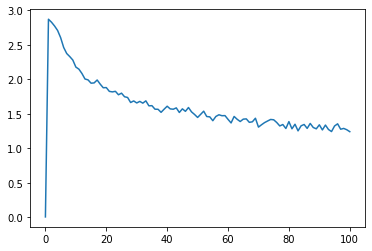

In [10]:
import matplotlib.pyplot as plt
plt.plot(all_losses)

In [29]:
def evaluate(name_tensor):
    hidden = rnn.init_hidden()

    for letter_tensor in name_tensor:
        output, hidden = rnn(letter_tensor, hidden)
        
    return output

confusion_mat = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, category_tensor, name, name_tensor = random_training_example()
    category_i = all_categories.index(category)
    output = evaluate(name_tensor)
    guess, guess_i = category_from_output(output)
    confusion_mat[category_i][guess_i] += 1

for i in range(n_categories):
    confusion_mat[i] = confusion_mat[i] / confusion_mat[i].sum()


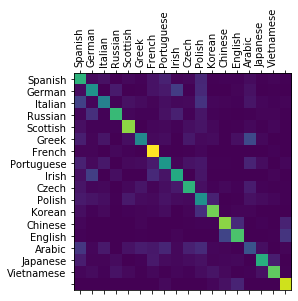

In [39]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
ax.matshow(confusion_mat.numpy())
ax.set_xticklabels(all_categories, rotation=90)
ax.set_yticklabels(all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))